In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
import pickle

# Material constant ranges from Table 1
material_constant_ranges = {
    "E": [60000e6, 210000e6],  # Young's modulus in MPa
    "sigma_y": [90e6, 1000e6],  # Yield stress in MPa
    "c1": [1e6, 250000e6],  # Kinematic hardening constants
    "c2": [1e6, 250000e6],
    "c3": [1e6, 250000e6],
    "gamma1": [0, 10000],
    "gamma2": [0, 10000],
    "gamma3": [0, 10000],
    "b": [1, 40],  # Isotropic hardening rate
    "Q": [1e6, 150e6],  # Saturation value for isotropic hardening
}

# Generate material constants using Latin Hypercube Sampling
def generate_material_constants_lhs(num_samples, ranges):
    num_variables = len(ranges)
    lhs_samples = lhs(num_variables, samples=num_samples)
    material_constants = []

    for i, (key, (low, high)) in enumerate(ranges.items()):
        samples = lhs_samples[:, i] * (high - low) + low
        material_constants.append(samples)

    return np.column_stack(material_constants)

# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return ((2.0 / 3.0) * c * eps_p_dot) - (gamma * sigma_k * np.abs(eps_p_dot))

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i,
                                 c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3                    
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 0, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial-E*delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(num_samples, num_strain_samples, lb, ub, ranges):
    material_constants = generate_material_constants_lhs(num_samples, ranges)
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
    dataset = []

    for constants in material_constants:
        E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q = constants
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

        for eps in strain_history:
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i,
                c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y
            )

            # Store the data
            #back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = yield_function
            dataset.append([
                E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, b, Q, trial_phi, eps, sigma_updated, np.abs(eps_p)
            ])

    return np.array(dataset)

# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



2024-12-05 18:06:05.169308: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 18:06:05.169990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:06:05.172178: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:06:05.179424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 18:06:05.192140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler

In [4]:
# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

In [5]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [6]:
training = generate_dataset(num_samples=500, num_strain_samples=1500, lb=0.0001,ub=0.0002, ranges=material_constant_ranges)
#test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
#test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [7]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [8]:
df.head(50)

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,stress_rm,plastic_strain
0,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-4.527065e+08,0.000155,2.721103e+07,0.000000
1,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-4.279413e+08,0.000296,5.197623e+07,0.000000
2,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-3.976534e+08,0.000468,8.226413e+07,0.000000
3,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-3.729928e+08,0.000608,1.069248e+08,0.000000
4,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-3.420015e+08,0.000785,1.379161e+08,0.000000
5,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-3.148334e+08,0.000939,1.650842e+08,0.000000
6,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-2.858200e+08,0.001104,1.940976e+08,0.000000
7,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-2.551005e+08,0.001279,2.248171e+08,0.000000
8,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-2.328608e+08,0.001405,2.470567e+08,0.000000
9,1.757814e+11,4.799176e+08,1.485536e+11,9608.457403,1.756873e+11,6914.437044,4.866523e+10,8092.352096,38.353873,7.366838e+07,-2.127922e+08,0.001520,2.671253e+08,0.000000


In [9]:
# Separate features and target
X = training[:, :-3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training[:, -1]   # Targets (plastic_strain)

In [10]:
X_normalized, scaler_X= normalize_dataset(X)
y = y.reshape(-1, 1)
y_normalized, scaler_y= normalize_dataset(y)

In [11]:
# Build the neural network model
print("Building the neural network model...")
model = build_model(X.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X_normalized, 
    y_normalized, 
    epochs=1000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Building the neural network model...
Training the model...
Epoch 1/1000


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 0.0038 - mae: 0.0367 - val_loss: 2.4630e-05 - val_mae: 0.0039
Epoch 2/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 5.4667e-04 - mae: 0.0039 - val_loss: 1.6361e-05 - val_mae: 0.0030
Epoch 3/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 2.0574e-04 - mae: 0.0028 - val_loss: 1.0756e-05 - val_mae: 0.0022
Epoch 4/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 3.5962e-05 - mae: 0.0020 - val_loss: 8.8189e-06 - val_mae: 0.0019
Epoch 5/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 9.6396e-06 - mae: 0.0016 - val_loss: 7.2618e-06 - val_mae: 0.0016
Epoch 6/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 9.2367e-06 - mae: 0.0014 - val_loss: 6.4281e-06 - val_mae: 0.0014
Epoch 7/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 3.8634e-06 - mae: 0.0011 - val_loss: 5.4356e-06 - val_mae: 0.0011
Epoch 8/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2.3830e-06 - mae: 9.5448e-04 - val_loss: 5.

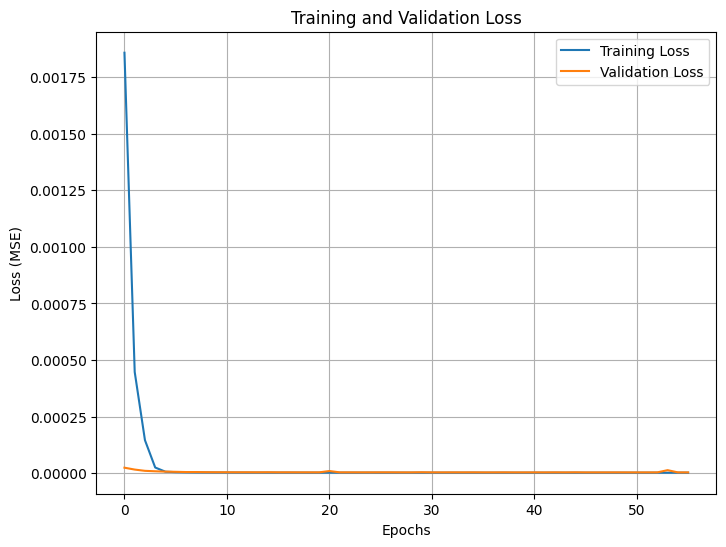

In [12]:
# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

In [13]:
# Save the model
model.save('plastic_strain_predictor_model_abs_05_12.h5')
#print("Model saved as 'plastic_strain_predictor_model.h5'")

with open('scaler_X_abs.pkl', 'wb') as file:
    pickle.dump(scaler_X, file)
with open('scaler_y_abs.pkl', 'wb') as file:
    pickle.dump(scaler_y, file)